*Start by running helpers/ scripts first, then run this notebook*

In [1]:
# !pip install sentence_transformers xlrd


JOKES_SEP = '\n\n\n'


In [2]:
with open('data/jokes.txt', 'r') as f:
    text = f.read()
jokes = text.split(JOKES_SEP)[:100] # 101 element is '\n'
jokes[0]

"Why are there so many Jones's in the phone book?\nBecause they all have phones."

## Extract embeddings

In [3]:
from sentence_transformers import SentenceTransformer
bert_transformer = SentenceTransformer('bert-base-cased')

jokes_embeddings = bert_transformer.encode(jokes)
jokes_embeddings.shape

/home/jakubner/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-23 07:31:37.815569: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 07:31:37.890927: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 07:31:38.237448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 07:31:39.965047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning:

(100, 768)

In [38]:
jokes_embeddings[0].shape

(768,)

In [4]:
import numpy as np
import pandas as pd


def load_ratings(filename) -> np.ndarray:
    """ratings: N x 101"""
    ratings = pd.read_excel(filename, header=None)
    return ratings.to_numpy()

ratings_data = np.concatenate([
    load_ratings('raw_data/jester-data-1.xls'), 
    load_ratings('raw_data/jester-data-2.xls'),
    load_ratings('raw_data/jester-data-3.xls'),
    ], axis=0)
ratings_data.shape

(73421, 101)

In [18]:
ratings = ratings_data[: , 1:]

# if value is 99, it means that user didn't rate the joke
print(f'{ratings[ratings == 99].shape[0]} null values') 
ratings[ratings == 99] = np.nan

ratings_means = np.nanmean(ratings, axis=0)
ratings_means.max(), ratings_means.min()

0 null values


(3.3625929395733083, -3.7045409911996297)

In [10]:
ratings.shape

(73421, 100)

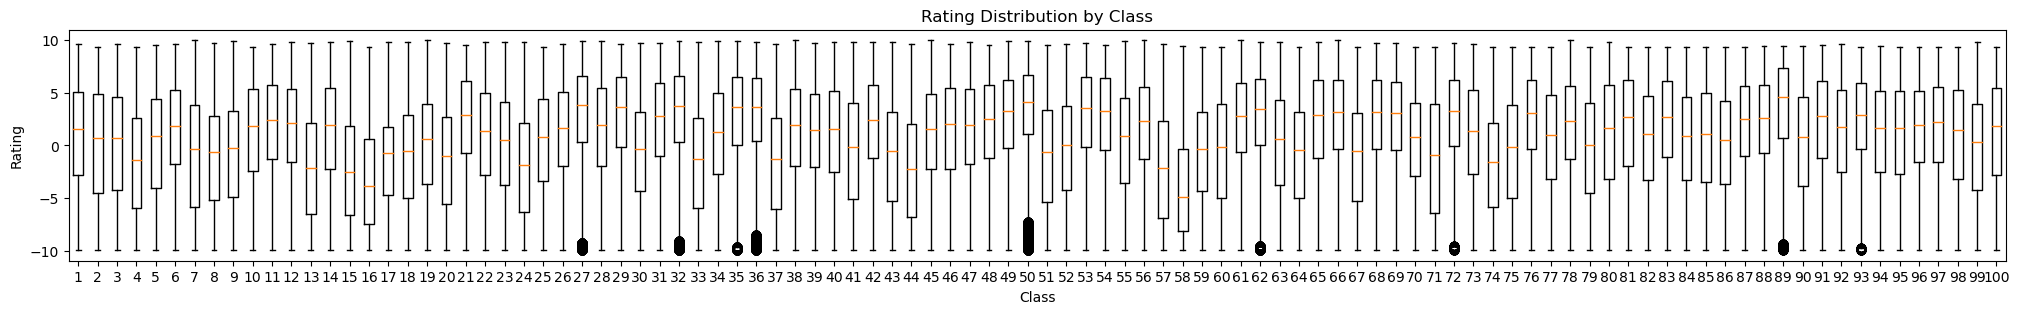

In [11]:
# plot relation between joke number and its rating
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 3))

bool_mask = ~np.isnan(ratings)
plotting_data = [d[m] for d, m in zip(ratings.T, bool_mask.T)]

plt.boxplot(plotting_data)
plt.title('Rating Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Rating')
plt.show()

In [12]:
# TODO: set outliers to mean value
from IPython.display import display, Markdown

def print_md(string):
    display(Markdown(string))

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# train & test 0.9, validation 0.1
X, X_validation, y, y_validation = train_test_split(jokes_embeddings, ratings_means, test_size=0.1, random_state=42)

print("Training & Testing set shape:", X.shape, y.shape)
print("Validation set shape:", X_validation.shape, y_validation.shape)

Training & Testing set shape: (90, 768) (90,)
Validation set shape: (10, 768) (10,)


In [46]:
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

def evaluate_model(model, title, EPOCHS=200):
    X, X_validation, y, y_validation = train_test_split(jokes_embeddings, ratings_means, test_size=0.1, random_state=42)

    # From documentation: "This model optimizes the squared error using LBFGS or stochastic gradient descent."
    test_errors = []
    validation_errors = []
    N_SPLITS = 5
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    for i in range(EPOCHS):
        epoch_validation_errors = 0
        epoch_test_errors = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.partial_fit(X_train, y_train)
            y_pred = model.predict(X_test)
            epoch_test_errors += mean_squared_error(y_test, y_pred)

            y_pred = model.predict(X_validation)
            validation_error = mean_squared_error(y_validation, y_pred)
            epoch_validation_errors += validation_error

        #     print(f'Epoch: {i}, Test error: {round(model.loss_, 3)}, Validation error: {round(validation_error, 3)}')
        test_errors.append(epoch_test_errors / N_SPLITS)
        validation_errors.append(epoch_validation_errors / N_SPLITS)


    plt.plot(range(EPOCHS), test_errors, label='Test error')
    plt.plot(range(EPOCHS), validation_errors, label='Validation error')
    plt.legend()
    plt.title(title)
    plt.ylim(0, 5.0)
    plt.show()

    weights = model.coefs_

    # Flatten the weights
    flattened_weights = np.concatenate([w.flatten() for w in weights])

    # Plot the weight distribution
    plt.hist(flattened_weights, bins=50, range=(-0.8, 0.8))
    plt.title('Weight Distribution ' + title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()



In [21]:
default_settings = {
  'learning_rate': 'constant',
  'activation': 'relu',
  'solver': 'sgd',
  'alpha': 0.0
}

### Results of the MLP with defaults parameters over the epochs

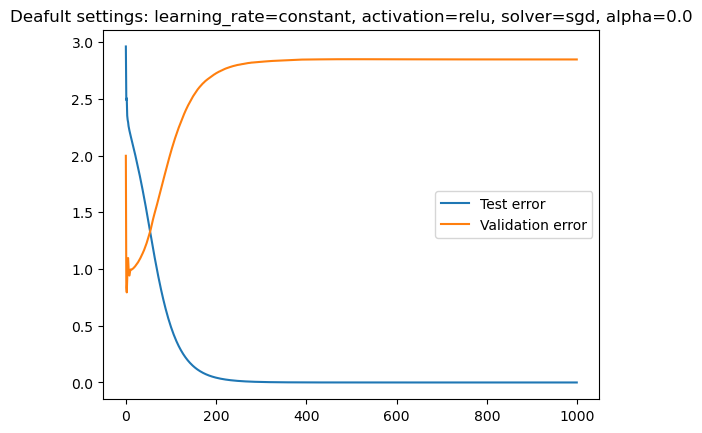

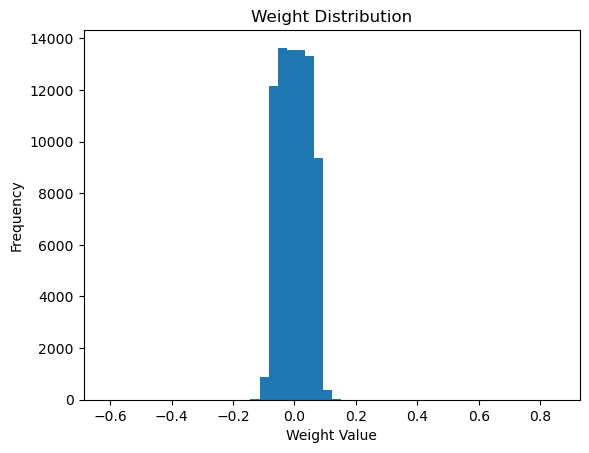

In [22]:
evaluate_model(
  MLPRegressor(**default_settings),
  title='Deafult settings: learning_rate=constant, activation=relu, solver=sgd, alpha=0.0'
)

### Impact of different learning_rate and learning_rate_init

### Learning rate: constant

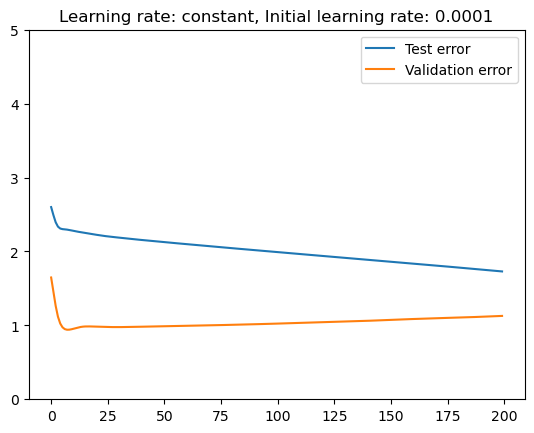

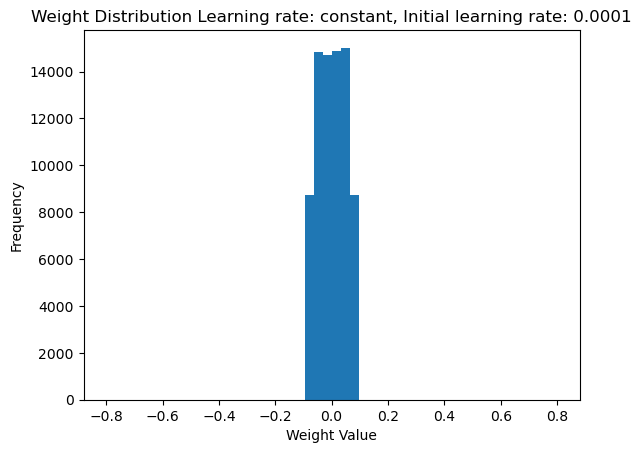

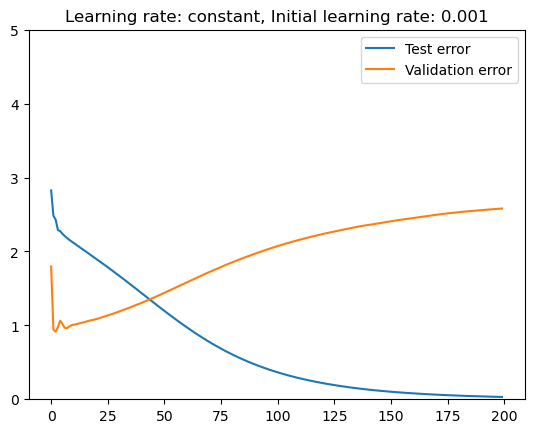

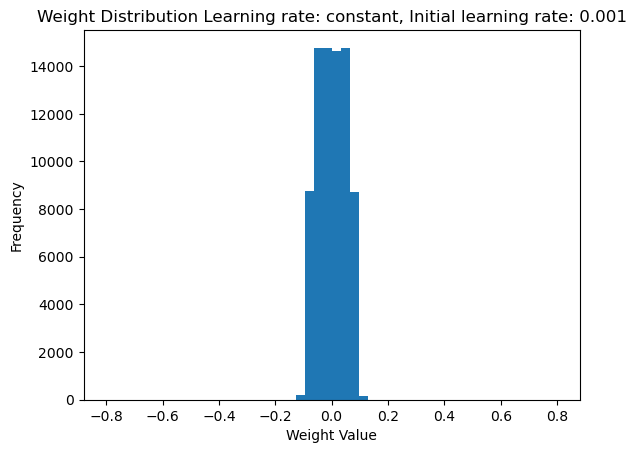

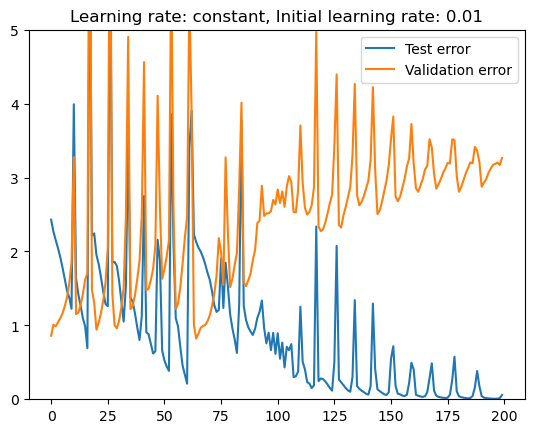

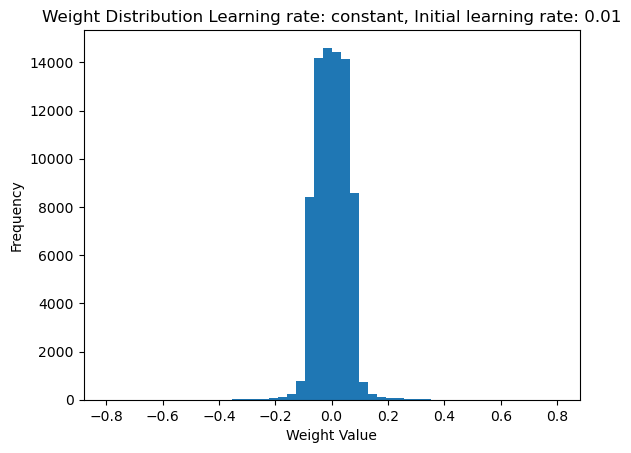

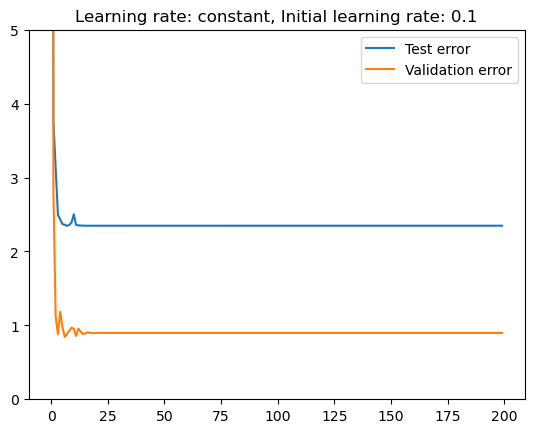

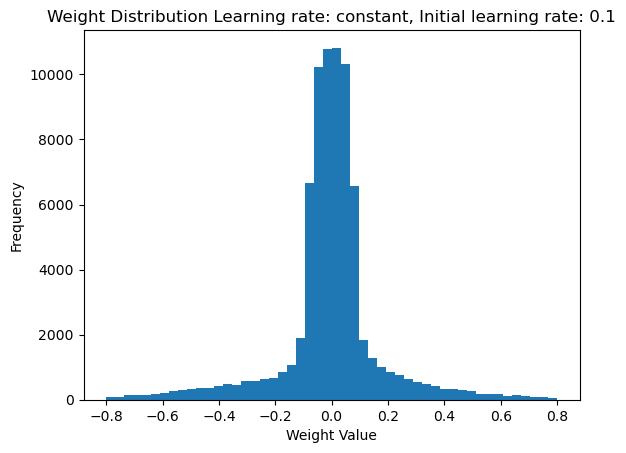

### Learning rate: adaptive

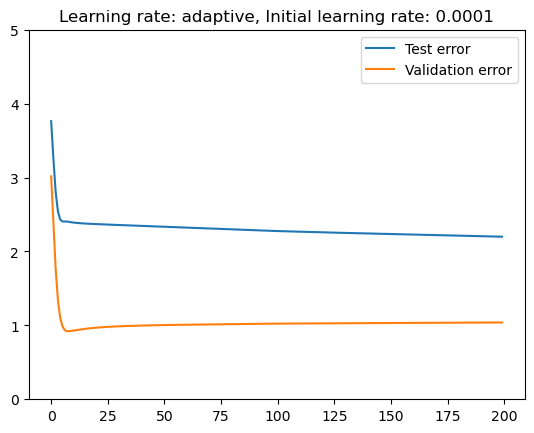

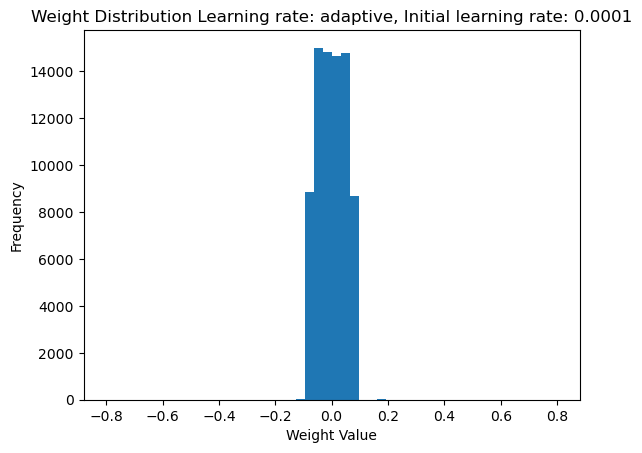

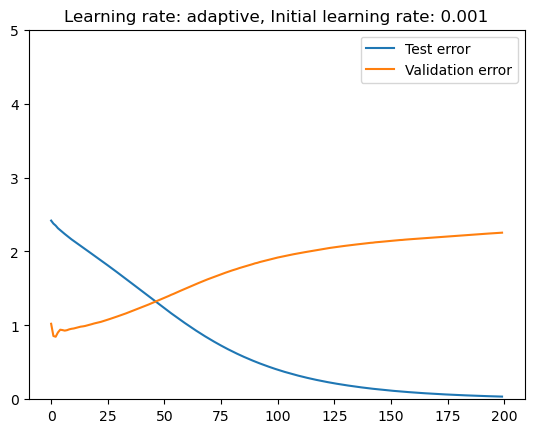

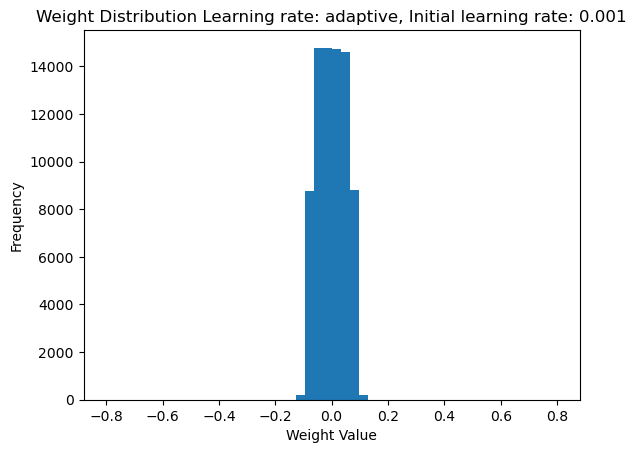

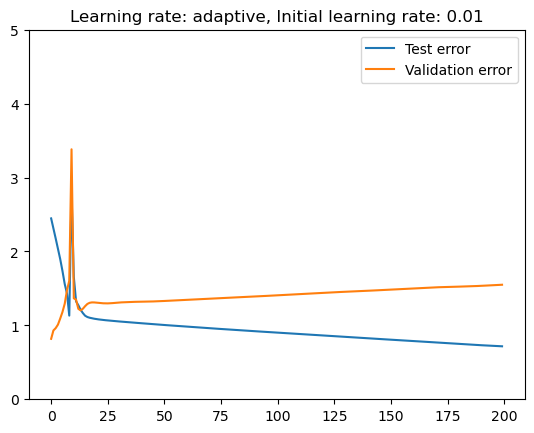

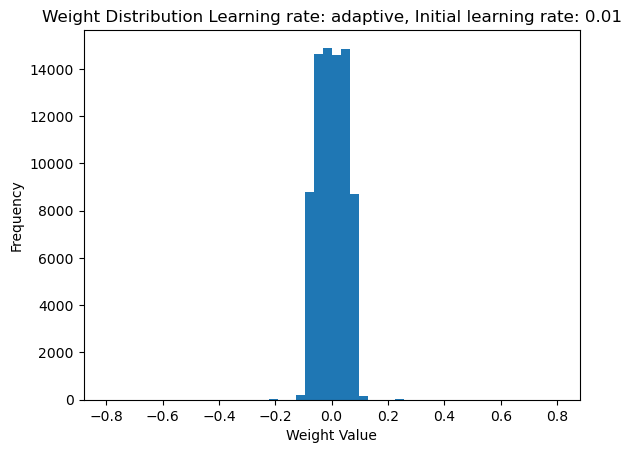

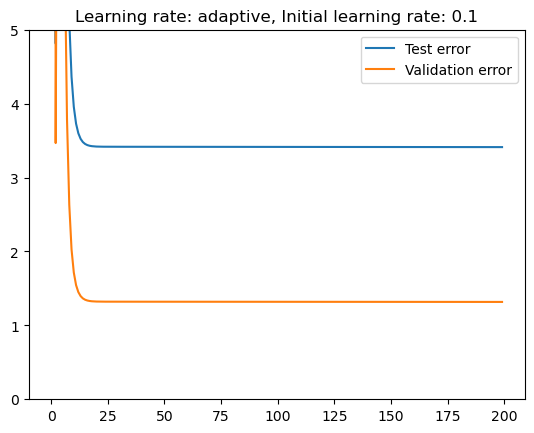

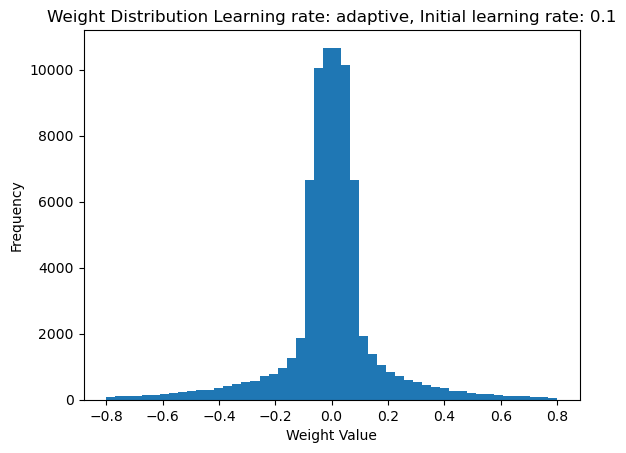

### Learning rate: invscaling

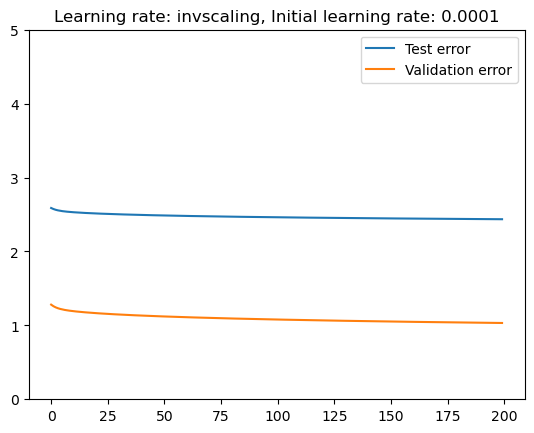

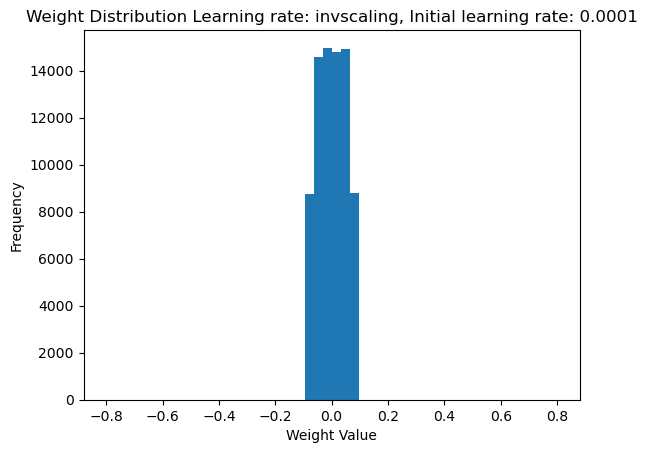

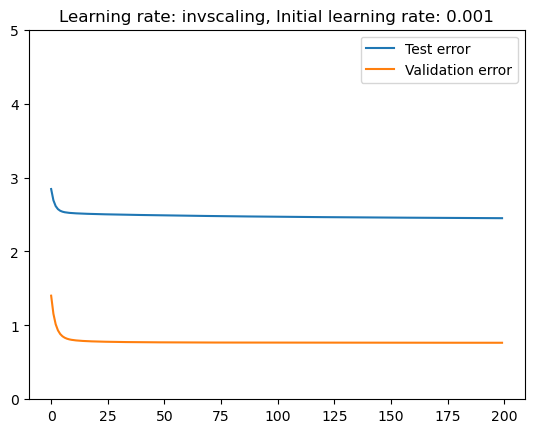

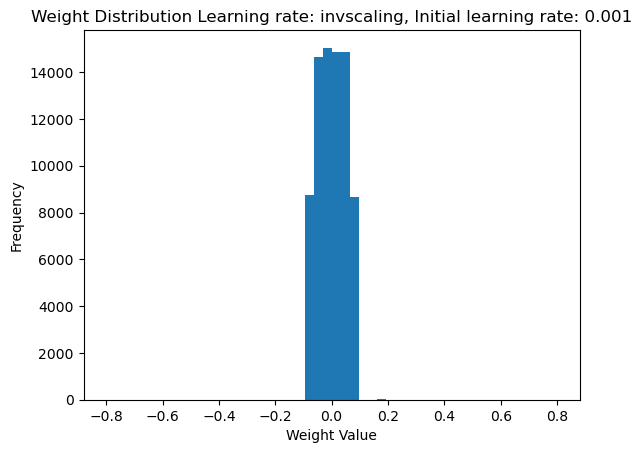

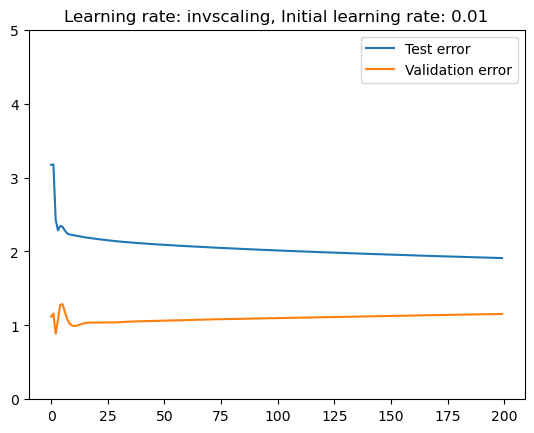

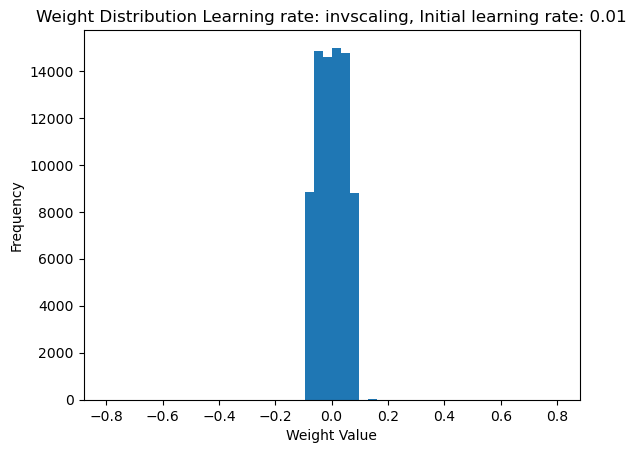

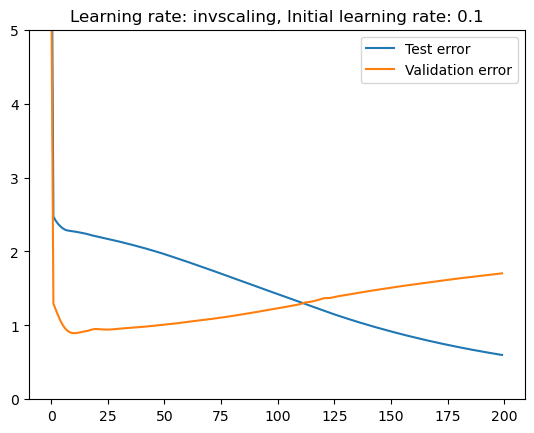

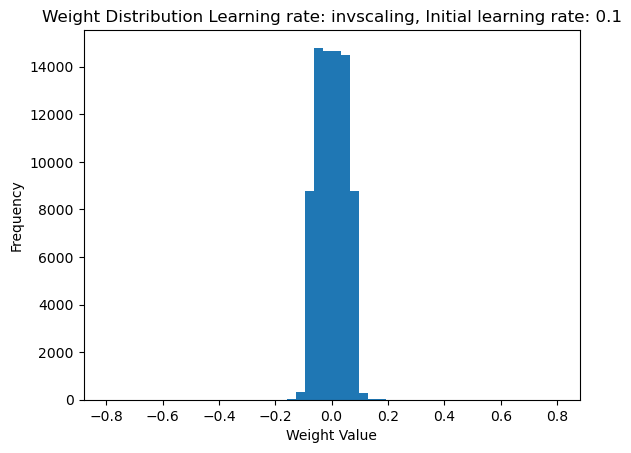

In [41]:
learn_rates = ['constant', 'adaptive', 'invscaling']
init_rates = [0.0001, 0.001, 0.01, 0.1]
settings = default_settings.copy()

for learn_rate in learn_rates:
  print_md(f'### Learning rate: {learn_rate}')
  for init_rate in init_rates:
    settings['learning_rate'] = learn_rate
    settings['learning_rate_init'] = init_rate
    evaluate_model(MLPRegressor(**settings), f'Learning rate: {learn_rate}, Initial learning rate: {init_rate}')

### Impact of hidden layers

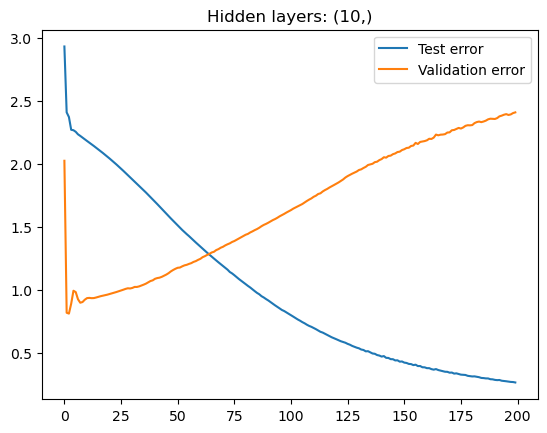

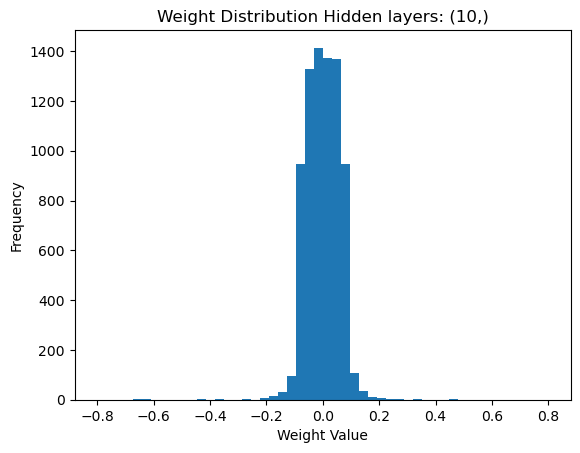

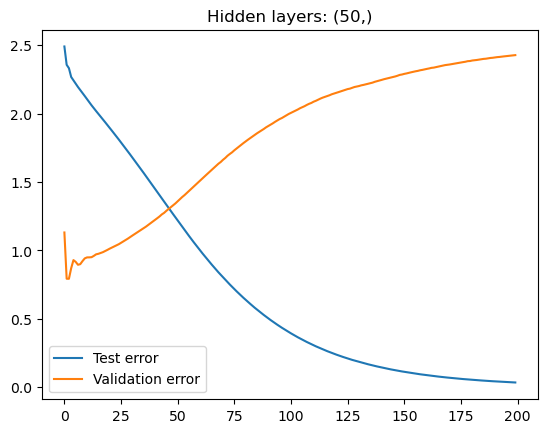

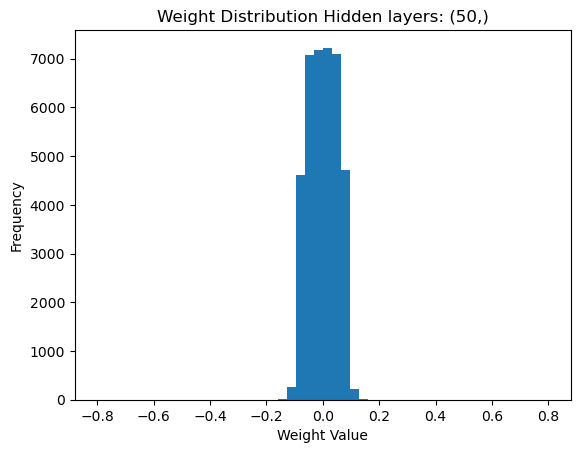

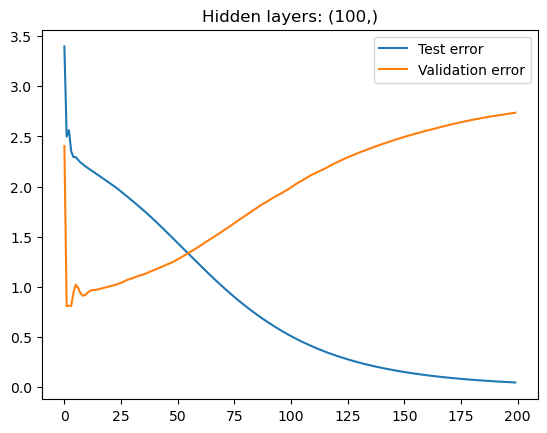

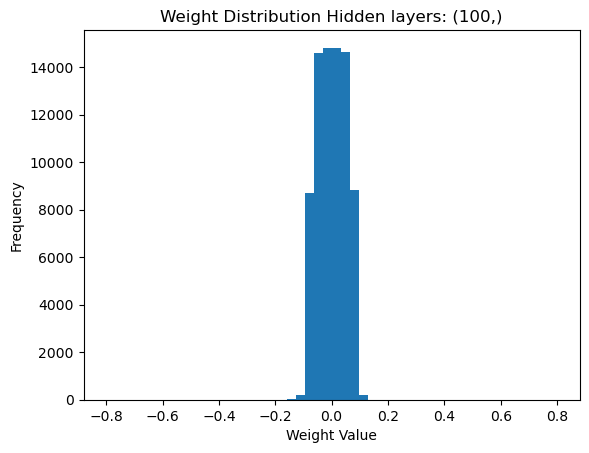

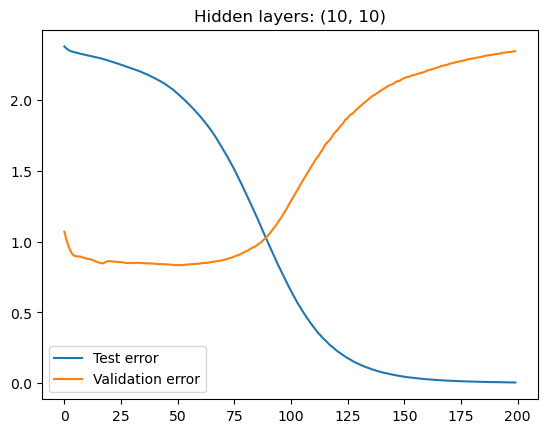

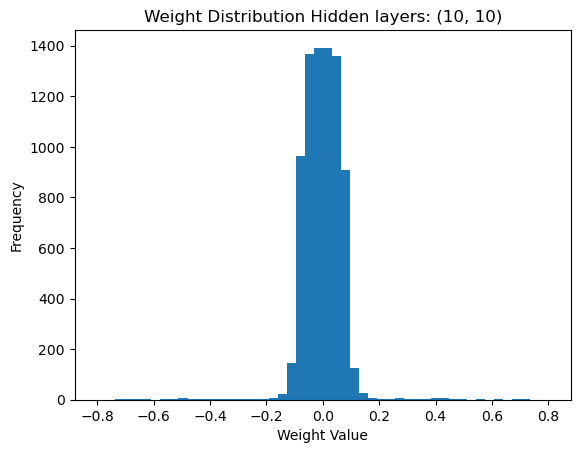

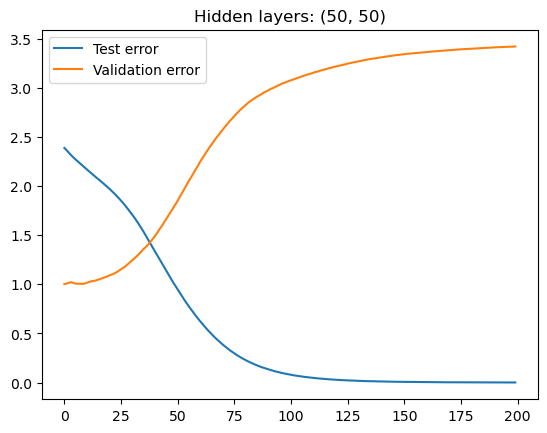

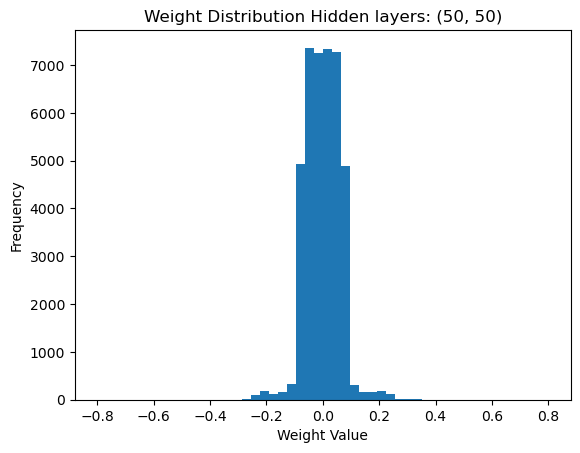

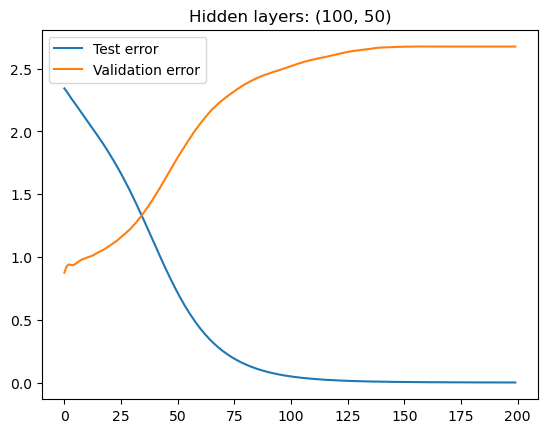

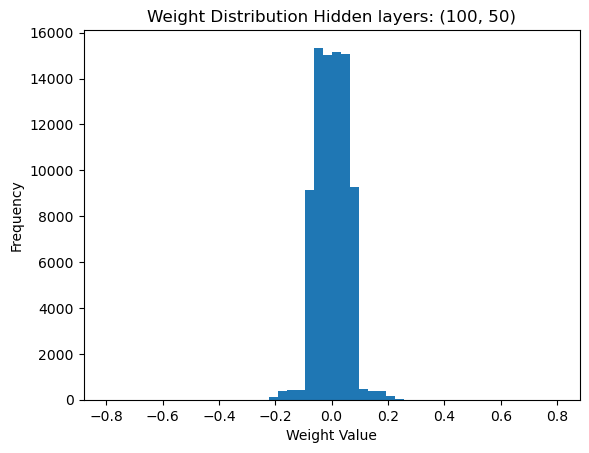

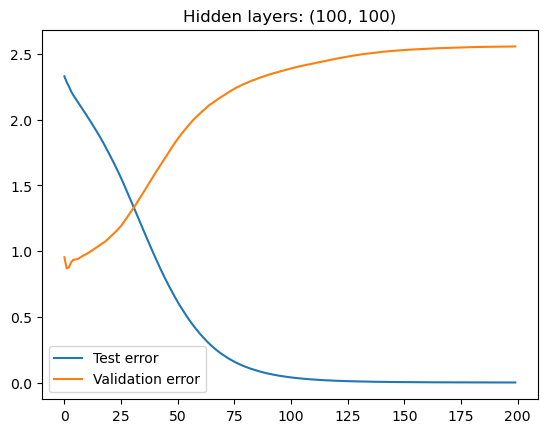

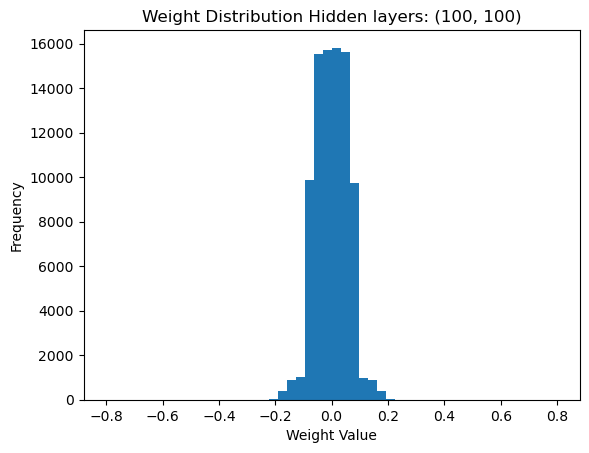

In [37]:
hidden_layers = [ 
  (10,), (50,), (100,),
  (10, 10), (50, 50), (100, 50), (100, 100),
]
settings = default_settings.copy()

for hidden_layer in hidden_layers:
  settings['hidden_layer_sizes'] = hidden_layer
  evaluate_model(MLPRegressor(**settings), f'Hidden layers: {hidden_layer}')

## Train a MLP with the best parameters and validate it

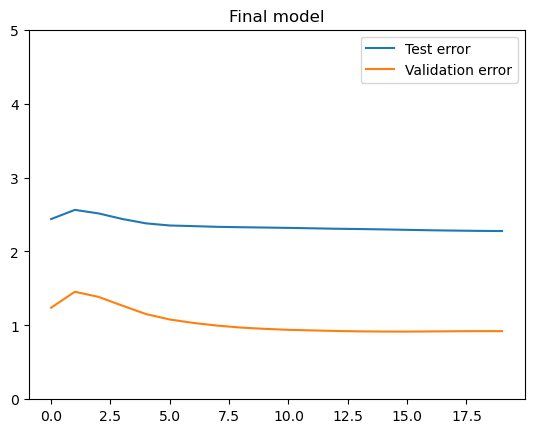

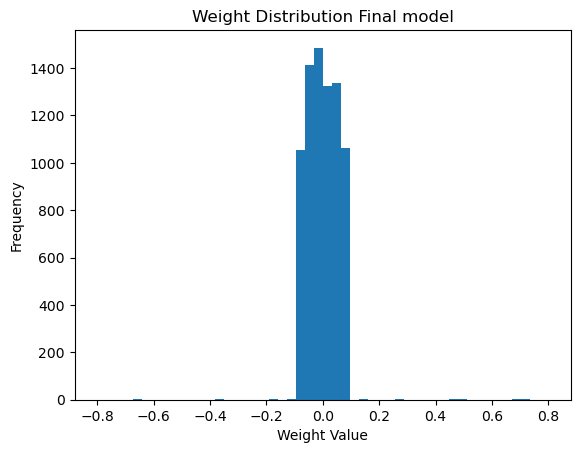

In [182]:
  
settings = default_settings.copy()
settings['learning_rate'] = 'invscaling'
settings['learning_rate_init'] = 0.01
settings['hidden_layer_sizes'] = (10,)

model = MLPRegressor(**settings)
evaluate_model(model, 'Final model', 20)

In [183]:
person1 = 'pole'
person2 = 'priest'
joke1 = f'{person1} comes to the doctor... And there is a {person2}.'

person1 = 'Pole'
person2 = 'Pole'
joke2 = f'{person2} comes to the doctor... And there is a {person1}.'

person1 = 'Michael'
person2 = 'Anastasy'
joke3 = f'{person2} comes to the doctor... And there is a {person1}.'

joke4 = 'jewish jewish jewish jewish... jewish people'
joke_embedding = bert_transformer.encode([
  joke1, joke2, joke3, joke4
])
model.predict(joke_embedding)


array([0.70173365, 0.6958765 , 0.80465585, 0.5321303 ], dtype=float32)

In [176]:
joke1, joke2, joke3, joke4

('pole comes to the doctor... And there is a priest.',
 'Pole comes to the doctor... And there is a Pole.',
 'Anastazja comes to the doctor... And there is a Zbigniew.',
 'polish people polish people... polish people')